V. 07.2020, S. Kaliyugarasan and A.S. Lundervold

# Introduction

This notebook constructs and evaluates a classifier tasked with predicting nodule malignancy from CT. 

# Setup

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
import sys 
import os.path
from pathlib import Path

In [ ]:
sys.path.append("../src/")
sys.path.append("../src/fastai_3d_extensions/network_and_models")
sys.path.append("../src/fastai_3d_extensions/vision")

In [ ]:
from data import * 
from models import *
from interpretation import NiiClassificationInterpretation 
from transform import *
from learner import create_learner
from tta import TTA
from datasets import download_and_preprocess_lidc_idri_tabular_data, get_img_dir

In [ ]:
from sklearn.model_selection import train_test_split

We are going to use the method `download_and_preprocess_lidc_idri_tabular_data()`  which will download the necessary tabular data for LIDC-IDRI and generate a training DataFrame and a test DataFrame. Note that you have to download the images first using the script `../src/prepare_images.py`.

In [ ]:
%time download_and_preprocess_lidc_idri_tabular_data()

Downloading: 100%|██████████| 254k/254k [00:00<00:00, 435kB/s] 
Downloading: 100%|██████████| 46.1k/46.1k [00:00<00:00, 150kB/s] 


Preprosessing LIDC-IDRI metadata
CPU times: user 14.9 s, sys: 116 ms, total: 15 s
Wall time: 17.3 s


In [ ]:
NB_DIR = Path.cwd()
LOCAL_DATA = NB_DIR/'..'/'local_data'
PROCESSED_DATA = LOCAL_DATA/'processed'

# Looking at the data

In [ ]:
# get path to data stored when running the script `../src/prepare_images.py`
DATA_DIR  = get_img_dir()
IMG_PATH = DATA_DIR/'interim'

In [ ]:
df = pd.read_csv(PROCESSED_DATA/'train_data_patient_level_diagnosis.csv')

In [ ]:
df.head()

,path,subject_id,nodule,study_description,scan_session,study_date,modality,scan_description,manufacturer,manufacturer_model,...,radiologists_calcification_def,radiologists_sphericity_score,radiologists_margin_score,radiologists_texture_def,radiologists_malignancy_score,median_malignancy_score,malignancy,patient_level_diagnosis,binary_patient_level_diagnosis,usage
0,LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.60...,LIDC-IDRI-0001,1,NaN,1,01/01/2000,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed Plus,...,[6],[4],[4],[5],[5],5.0,malignant,NaN,NaN,train
1,LIDC-IDRI-0002/1.3.6.1.4.1.14519.5.2.1.6279.60...,LIDC-IDRI-0002,1,NaN,1,01/01/2000,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,...,[6],[5],[1],[1],[5],5.0,malignant,NaN,NaN,train
2,LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.60...,LIDC-IDRI-0003,2,NaN,1,01/01/2000,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,...,[6],[5],[4],[4],[4],4.0,malignant,NaN,NaN,train
3,LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.60...,LIDC-IDRI-0003,3,NaN,1,01/01/2000,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,...,[6],[5],[5],[5],[2],2.0,benign,NaN,NaN,train
4,LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.60...,LIDC-IDRI-0003,4,NaN,1,01/01/2000,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,...,"[6, 6]","[5, 4]","[5, 5]","[5, 5]","[5, 3]",4.0,malignant,NaN,NaN,train


Find the largest size in all axis, for use in the below data loader.

In [ ]:
LARGEST_IMG_SIZE = get_largest_img_size(img_list=df.path.values, path=IMG_PATH)
LARGEST_IMG_SIZE

[88, 91, 62]

## Split training data into train and val

We split off a validation data set and store what data should be used for training and for validation in the training data frame.

In [ ]:
_, val_df, _, _ = train_test_split(df, df.malignancy, test_size=0.05, random_state=42, stratify=df.malignancy)

In [ ]:
for subject_id in val_df.subject_id.unique(): df.loc[df.subject_id == subject_id, 'usage'] = 'val'

In [ ]:
df.usage.value_counts()

train    711
val      114
Name: usage, dtype: int64

In [ ]:
df_train = df.loc[df.usage == 'train']
df_train.malignancy.value_counts()

benign       464
malignant    247
Name: malignancy, dtype: int64

Oversample the malignant class in training set by duplicating the corresponding rows. 

In [ ]:
df = df.append(df_train.loc[df_train.malignancy == 'malignant'], ignore_index=True) #upsampling

In [ ]:
df.usage.value_counts()

train    958
val      114
Name: usage, dtype: int64

In [ ]:
df['usage'] = df['usage'].apply(lambda x: True if x =='val' else False) 

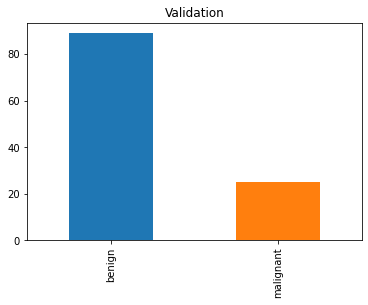

In [ ]:
df.loc[df.usage].malignancy.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Validation'); #flyttet egentlig over 25 subjekter som var malignant i train til val for aa faa bedre litt bedre indikasjon 

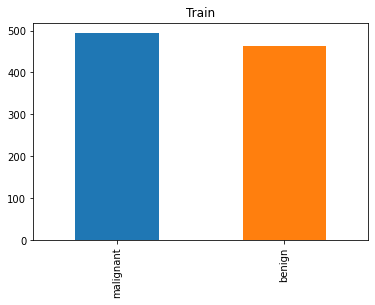

In [ ]:
df.loc[~df.usage].malignancy.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Train');

## Create data set

Use the custom NiiImageList from `data.py` class to create a labelled data set.

In [ ]:
src = NiiImageList.from_df(df, IMG_PATH).split_from_df(col='usage').label_from_df(cols='malignancy')

## Create model

In [ ]:
#Dropout probability 
dropout_ps=0.4

#Batch size
bs = 128

> **Note:** If you get out of memory error when running this notebook, click Kernel->Restart, use a smaller batch size, and try again.

In [ ]:
out_features = df.malignancy.nunique() 
model,layer_groups = create_model(out_features=out_features, dropout_ps=dropout_ps)

### Data augmentation and progressive resizing
One way to create more data is by utilizing a technique called data augmentation. One creates "new" training data from the existing by applying simple transformations (e.g., rotation, zooming, flipping, etc). However, note that data augmentation should be used with caution, taking care not to change the meaning of the images. 

Below, in the `get_transform()` function, we set `rescale=2`. Starting training with small images than progressively increasing to larger images is a great way to reduce training time and in some cases increase model performance. This approach is known as progressive resizing. 
It acts as a form of data augmentation and can help to reduce overfitting.

In [ ]:
data = (src.transform(get_transforms(largest_img_size=LARGEST_IMG_SIZE, rescale=2, degrees=35)).databunch(bs=bs))

Here is how the training data looks like:

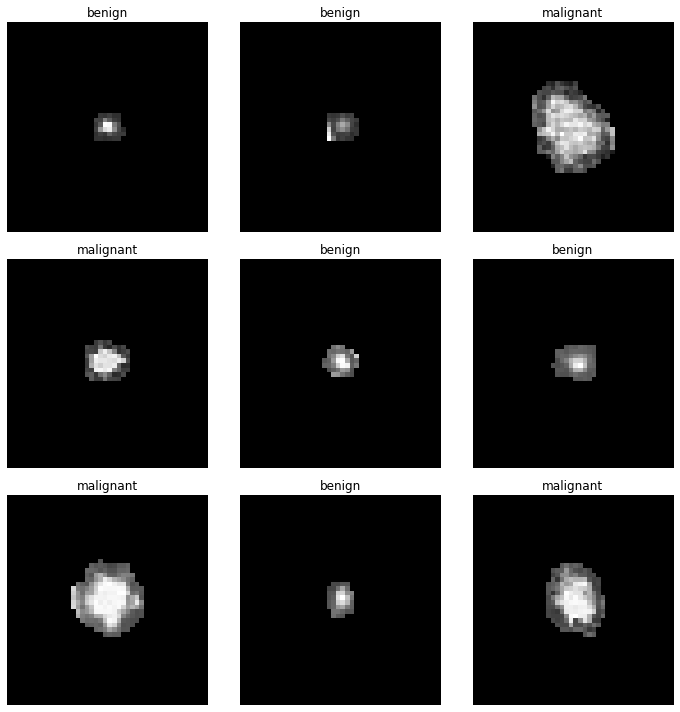

In [ ]:
data.show_batch(rows=3, figsize=(10,10), anatomical_plane='sagittal')

Now we can create a learner from our chosen model architecture and data:

In [ ]:
learn = create_learner(data=data, model=model, layer_groups=layer_groups, metrics=accuracy)

A summary of our custome-made 3D-CNN 

In [ ]:
learn.summary()

DataParallel
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               [64, 44, 46, 31]     1,792      True      
______________________________________________________________________
BatchNorm3d          [64, 44, 46, 31]     128        True      
______________________________________________________________________
ReLU                 [64, 44, 46, 31]     0          False     
______________________________________________________________________
MaxPool3d            [64, 22, 23, 15]     0          False     
______________________________________________________________________
Conv3d               [64, 22, 23, 15]     110,656    True      
______________________________________________________________________
BatchNorm3d          [64, 22, 23, 15]     128        True      
______________________________________________________________________
ReLU                 [64, 22, 23, 15]     0          False     
_________________________________________________

# Training

`lr.lr_find()` helps us to find an optimum learning rate value. It uses the technique described in <a href="https://arxiv.org/abs/1506.01186"> Cyclical Learning Rates for Training Neural Networks </a>. The learning rate is increased from a small value until the loss stops decreasing. Note that the optimal learning rate can change as we train our model. Hence, we re-run this function later in this notebook.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 2.29E-03


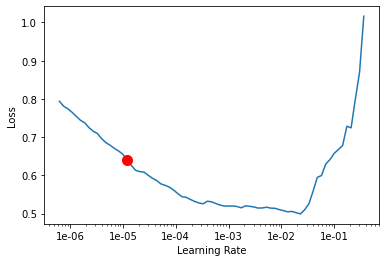

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

3.311311214825911e-06

## The 1cycle policy
`learn.fit_one_cycle()` is fastai's implementations of Leslie Smith's <a href="https://arxiv.org/pdf/1803.09820.pdf"> 1cycle policy </a> (e.g., learning rate changes during the training, related to what is called superconvergence)).  

In [ ]:
learn.fit_one_cycle(20,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.820741,0.924567,0.292553,00:06
1,0.775123,1.164415,0.292553,00:07
2,0.697410,0.994200,0.292553,00:07
3,0.620821,0.584089,0.739362,00:06
4,0.565042,0.396232,0.840426,00:06
5,0.520230,0.350352,0.851064,00:06
6,0.486665,0.344977,0.867021,00:06
7,0.460238,0.359578,0.856383,00:06
8,0.437374,0.354910,0.840426,00:07
9,0.414867,0.362401,0.845745,00:06


In [ ]:
learn.save('model_resized')

## Train using larger images

In [ ]:
bs = 128 # Note: You may have to change this if you run out of GPU memory.

In [ ]:
data = src.transform(get_transforms(largest_img_size=LARGEST_IMG_SIZE, degrees=35)).databunch(bs=bs)

In [ ]:
learn = create_learner(data=data, model=model, layer_groups=layer_groups, metrics=accuracy)

Load the weights for the previous model trained on the small images and freeze the early layers, only retraining the final layer.

In [ ]:
learn.load('model_resized');
learn.freeze_to(1);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.63E-04


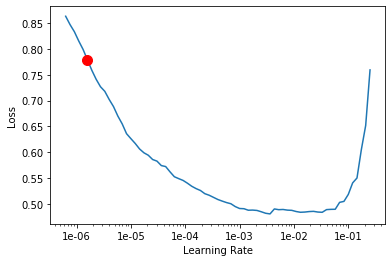

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

1.5848931924611132e-06

The early layers in CNNs often end up learning low-level features, such as edges, colors shapes, etc. Therefore we would expect them to need less fine-tuning for the original sized image. For this reason, we will use a lower learning rate for early layers compared to the later layers. This technique is called discriminative learning rates.
With `slice(lr)` the final layer gets `lr` value and earlier layers get `lr/3`. If two arguments are passed to the `slice()` function, then the early layers get the value from the first argument and final layers get the value from the second argument, and the layers between them get learning rate between values.
Note that if `slice()` function is not used, then all the layers get the same learning rate. 

In [ ]:
learn.fit_one_cycle(10,slice(min_grad_lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.886672,0.666520,0.627660,00:09
1,0.859959,0.665045,0.622340,00:09
2,0.811115,0.613890,0.718085,00:09
3,0.749038,0.549227,0.765957,00:09
4,0.696851,0.496975,0.803191,00:09
5,0.651462,0.457650,0.829787,00:09
6,0.611906,0.436464,0.835106,00:09
7,0.584252,0.426855,0.845745,00:09
8,0.567955,0.425989,0.851064,00:09
9,0.554877,0.426496,0.845745,00:09


Try fine-tuning all the layers

In [ ]:
learn.unfreeze();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 7.59E-04


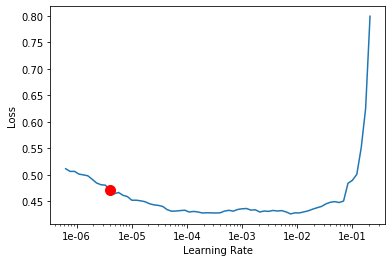

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

3.981071705534973e-06

In [ ]:
lr = 1e-05

In [ ]:
learn.fit_one_cycle(12,slice(lr/5, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.506291,0.394956,0.835106,00:13
1,0.468184,0.357708,0.851064,00:12
2,0.443541,0.327541,0.877660,00:12
3,0.425344,0.320318,0.888298,00:13
4,0.403845,0.326015,0.861702,00:13
5,0.388723,0.340787,0.867021,00:12
6,0.376348,0.331952,0.861702,00:12
7,0.364598,0.331937,0.872340,00:12
8,0.351781,0.338065,0.867021,00:12
9,0.342658,0.323716,0.872340,00:12


In [ ]:
learn.save('classification_original')

## Final model 

We train our final model on the entire training data set (i.e. also the validation data) for a couple of iteration, with a small learning rate. This trick might give a performance and robustness boost.

In [ ]:
df = pd.read_csv(PROCESSED_DATA/'train_data_patient_level_diagnosis.csv')
df = df.append(df.loc[df.malignancy == 'malignant'], ignore_index=True) #upsampling for final model 

In [ ]:
src = NiiImageList.from_df(df, IMG_PATH).split_none().label_from_df(cols='malignancy')

In [ ]:
data = src.transform(get_transforms(largest_img_size=LARGEST_IMG_SIZE, degrees=35)).databunch(bs=bs)

In [ ]:
learn = create_learner(data=data, model=model, layer_groups=layer_groups, metrics=accuracy)

In [ ]:
learn.load('classification_original');

In [ ]:
learn.fit_one_cycle(12,slice(lr/5, lr))

In [ ]:
learn.save('final_model')

# Model intepretation

In [ ]:
df = pd.read_csv(PROCESSED_DATA/'train_data_patient_level_diagnosis.csv')
df_test = pd.read_csv(PROCESSED_DATA/'test_data_patient_level_diagnosis.csv')
df = df.append(df_test, ignore_index=True)

In [ ]:
bs=1 #set the batch size to 1 in order to fit the inference on one GPU

In [ ]:
df['usage'] = df['usage'].apply(lambda x: True if x == 'test' else False)

In [ ]:
src = NiiImageList.from_df(df, IMG_PATH).split_from_df(col='usage').label_from_df(cols='malignancy')

In [ ]:
data = src.transform(get_transforms(largest_img_size=LARGEST_IMG_SIZE, degrees=35)).databunch(bs=bs)

In [ ]:
learn = create_learner(data=data, model=model, layer_groups=layer_groups, metrics=accuracy, mixed_precision=False, run_parallel=False)

In [ ]:
learn.load('final_model');

In [ ]:
ds_type = fvision.DatasetType.Valid
preds,y,losses= learn.get_preds(with_loss=True, ds_type=ds_type, n_batch=None)

In [ ]:
interp = NiiClassificationInterpretation(learn, preds, y, losses, ds_type=ds_type)

The accuracy of our model on the test data is:

In [ ]:
interp.accuracy()

0.9117647058823529

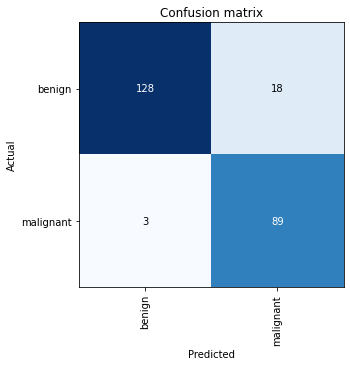

In [ ]:
interp.plot_confusion_matrix(figsize=(5, 5))

Here are som correctly classified nodules:

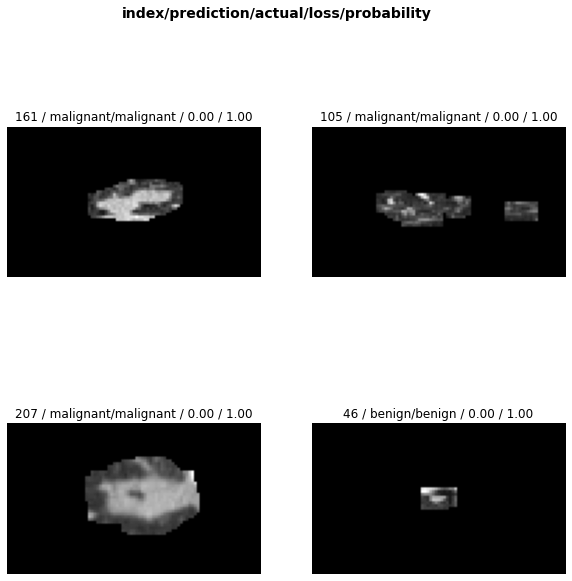

In [ ]:
interp.plot_losses(k=4,most_confused=False) 

Incorrectly classified

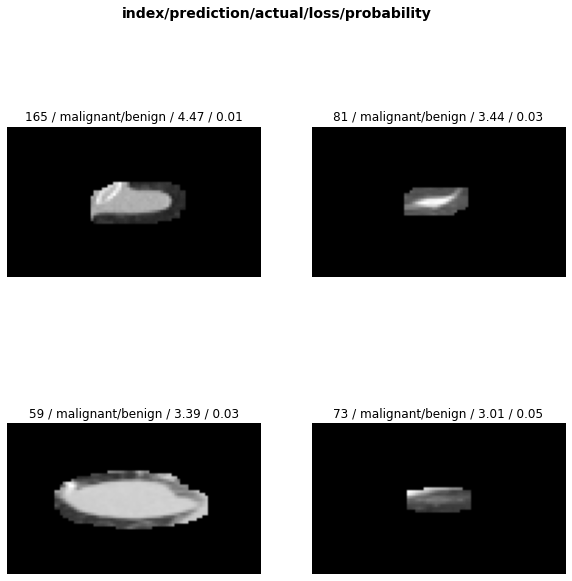

In [ ]:
interp.plot_losses(k=4, most_confused=True)

## Test time augmentation
Using augmentation during inference time is known as test time augmentation (TTA). 
TTA makes predictions on the original images along with predictions on a number of randomly augmented versions of these images (default is set to original image + four randomly augmented images). It then takes the average prediction from these images. This can often provide a small boost in prediction performance.

In [ ]:
preds, y_true = TTA(learn)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred_class = preds.argmax(axis=1)
accuracy_score(y_true,pred_class)

0.9159663865546218

# Explainable AI: Generating heatmaps
This is a visualization technique that can provide some understanding of model's decision making 

In [ ]:
from heatmap import * 
from image import show_image

In [ ]:
idx = 207

In [ ]:
m, xb, y = get_heatmap_elements(learn, data, idx=idx, ds_type=ds_type)

## CAM: Class activation maps

In [ ]:
cam_data = generate_cam(m, xb, y)

In [ ]:
xb_img = xb[0]
xb_img.shape

torch.Size([1, 88, 91, 54])

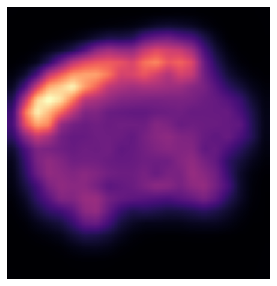

In [ ]:
show_image(img=xb_img, y=cam_data,figsize=(5,5), alpha=1, cmap_y='magma',anatomical_plane='sagittal');

## Grad-CAMs

In [ ]:
grad_cam_data = generate_grad_cam(m,xb,y)

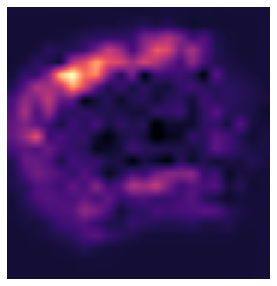

In [ ]:
show_image(img=xb_img, y=grad_cam_data, figsize=(5,5),alpha=1, cmap_y='magma', anatomical_plane='sagittal');